In [1]:
from collections import Counter
import itertools
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42

In [2]:
# Считывание данных
bad_cntr = pd.read_csv('../data/1/2-yarobl_bad_contracts.csv')
good_cntr = pd.read_csv('../data/1/2-yarobl_good_contracts.csv')
data = bad_cntr.append(good_cntr)

# Удаление пустых строк
data = data.dropna()

# Перемешивание данных
data = shuffle(data, random_state=random_seed)

print('Размер выборки: {}'.format(data.shape))
data.head(5)

Размер выборки: (11907, 20)


,cntrID,org_cntr_num,org_1s_sev,org_1s_sup_sev,sup_cntr_num,sup_cntr_avg_price,sup_cntr_avg_penalty,sup_no_pnl_share,sup_okpd_exp,sup_1s_sev,sup_1s_org_sev,sup_sim_price,supType,orgForm,price_higher_pmp,price_too_low,price,pmp,okpd,cntr_result
1701,1489889,2643,0.0,0.0,3,221400.0,0.0,1.0,1.00000,0,0.0,0.66667,3,0,0,1,249600.0,484210.00,0,0
3446,1410055,64,0.0,0.0,8,269412.0,0.0,1.0,1.00000,0,0.0,0.50000,3,13,0,0,379600.0,500000.00,0,1
3388,1394632,37,0.0,0.0,6,611850.0,0.0,1.0,1.00000,0,0.0,0.16667,3,13,0,0,280000.0,280000.00,0,1
673,1461932,2697,0.0,0.0,69,158718.0,0.0,1.0,1.00000,0,0.0,0.08696,3,13,0,0,144561.1,199395.00,0,0
4047,1547772,33,0.0,0.0,28,137404.0,0.0,1.0,0.60714,0,0.0,0.07143,2,8,0,0,28000.0,39421.44,0,0


In [3]:
data_prep = data.copy() # Для последующей предобработки категориальных значений
data_no_prep = data.copy() # Без предобработки категориальных значений

## Предобработка данных

Переменная `okpd` и `orgForm` на выборке принимают 643 и более 54 значений соответственно. При этом распределение этих
значений крайне неравномерное. 
- Для переменной `okpd` значение 0 наблюдается у 9761 объекта. Поэтому это значение было сохранено, а все остальные сгруппированы в одно новое. Итого, количество значений переменной `okpd` было уменьшено до 2
- Для переменной `orgForm` были сохранены 5 наиболее часто встречающихся значений, остальные были сгруппированы в 1. Итого, количество значений `orgForm` было уменьшено до 6.

In [4]:
# Счетчики значений
c_okpd, c_orgform = Counter(), Counter()
for org_form, okpd in zip(data.orgForm.values, data.okpd.values):
    c_okpd[str(okpd)] += 1
    c_orgform[org_form] += 1

# Наиболее популярные значения
print('Наиболее популярные сферы: {}'.format(c_okpd.most_common(5)))
print('Наиболее популярные формы организации заказчика: {}'.format(c_orgform.most_common(5)))

# Список со значениями наиболее популярных сфер контракта (ОКПД)
most_frequent_okpd_list = [int(elem[0]) for elem in c_okpd.most_common(5)]

# Список со значениями наименее популярных форм организации заказчика
most_frequent_orgform_list = [elem[0] for elem in c_orgform.most_common(5)]
rare_orgform_set = set(data.orgForm) - set(most_frequent_orgform_list)

# Группировка
data_prep.loc[data_prep['okpd']!=most_frequent_okpd_list[0], 'okpd'] = 111
for org_form in rare_orgform_set:
    data_prep.loc[data_prep['orgForm']==org_form, 'orgForm'] = 111

# One Hot Encoding
for column in ('supType', 'orgForm', 'okpd'):
    dummies = pd.get_dummies(data_prep[column], prefix=column[:4], drop_first=True)
    data_prep = pd.concat([data_prep, dummies], axis=1)
    data_prep.drop([column], inplace=True, axis=1)
    
print('Размер выбори без обработки категориальных переменных: {}'.format(data_no_prep.shape))
print('Размер выбори после обработки категориальных переменных: {}'.format(data_prep.shape))

Наиболее популярные сферы: [('0', 9761), ('869015000', 39), ('105140330', 26), ('421120000', 25), ('12410000', 22)]
Наиболее популярные формы организации заказчика: [(0, 4632), (13, 4143), (7, 1168), (8, 560), (45, 271)]
Размер выбори без обработки категориальных переменных: (11907, 20)
Размер выбори после обработки категориальных переменных: (11907, 26)


### Нормирование

In [5]:
column_names = data.loc[:,data.columns != 'cntr_result'].columns
columns_to_normalize = ['org_cntr_num', 'sup_cntr_num', 'sup_cntr_avg_price']
scaler1 = StandardScaler()
scaler2 = StandardScaler()

def preprocess_attributes(df, sc):
    # Формирование и предобработка массива признаков
    x_ = df.drop(['cntrID', 'cntr_result'], axis=1)
    x_.loc[x_['pmp']==0, 'pmp'] = 1
    x_.loc[x_['price']==0, 'price'] = 1
    x_['pmp'] = np.log(x_['pmp'])
    x_['price'] = np.log(x_['price'])
    x_.loc[:, columns_to_normalize] = sc.fit_transform(x_.loc[:, columns_to_normalize])
    return x_

X_cat, X = preprocess_attributes(data_prep, scaler1), preprocess_attributes(data_no_prep, scaler2)
X_cat_columns, X_columns = X_cat.columns, X.columns
X_cat, X = X_cat.values, X.values

# Целевая переменная
y = data.cntr_result.values

## Обучение моделей
- Logistic Regression (на выборке с предобработкой категориальных переменных)
- SVM  (на выборке с предобработкой категориальных переменных)
- Gradient Boosting
- CatBoost

In [6]:
reg_y_train_real = np.array([])
reg_y_test_real = np.array([])
reg_y_train_pred = np.array([])
reg_y_test_pred = np.array([])
reg_y_test_pred_proba = np.zeros((0, 2))

svc_y_train_real = np.array([])
svc_y_test_real = np.array([])
svc_y_train_pred = np.array([])
svc_y_test_pred = np.array([])
svc_y_test_pred_proba = np.zeros((0, 2))

gb_y_train_real = np.array([])
gb_y_test_real = np.array([])
gb_y_train_pred = np.array([])
gb_y_test_pred = np.array([])
gb_y_test_pred_proba = np.zeros((0, 2))

cb_y_train_real = np.array([])
cb_y_test_real = np.array([])
cb_y_train_pred = np.array([])
cb_y_test_pred = np.array([])
cb_y_test_pred_proba = np.zeros((0, 2))

In [7]:
reg = LogisticRegression()
svc = SVC(probability=True)
gb = GradientBoostingClassifier(random_state=random_seed)
cb = CatBoostClassifier(logging_level='Silent', random_state=random_seed)

In [8]:
start_time = time.time()
kfold_generator = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for idx, (train_index, test_index) in enumerate(kfold_generator.split(X_cat)):
    print('REG_SVC: обучение {} разбиения'.format(idx + 1))
    
    X_train = X_cat[train_index]
    X_test = X_cat[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]
    
    reg.fit(X_train, y_train)
    svc.fit(X_train, y_train)
    
    reg_y_train_real = np.concatenate((reg_y_train_real, y_train))
    reg_y_test_real = np.concatenate((reg_y_test_real, y_test))
    reg_y_train_pred = np.concatenate((reg_y_train_pred, reg.predict(X_train)))
    reg_y_test_pred = np.concatenate((reg_y_test_pred, reg.predict(X_test)))
    reg_y_test_pred_proba = np.concatenate((reg_y_test_pred_proba, reg.predict_proba(X_test))) 
    
    svc_y_train_real = np.concatenate((svc_y_train_real, y_train))
    svc_y_test_real = np.concatenate((svc_y_test_real, y_test))
    svc_y_train_pred = np.concatenate((svc_y_train_pred, svc.predict(X_train)))
    svc_y_test_pred = np.concatenate((svc_y_test_pred, svc.predict(X_test)))
    svc_y_test_pred_proba = np.concatenate((svc_y_test_pred_proba, svc.predict_proba(X_test)))
    
for idx, (train_index, test_index) in enumerate(kfold_generator.split(X)):
    print('GB_CB: обучение {} разбиения'.format(idx + 1))
    
    X_train = X[train_index]
    X_test = X[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]
    
    gb.fit(X_train, y_train)
    cb.fit(X_train, y_train, cat_features=[11, 12, 17])
    
    gb_y_train_real = np.concatenate((gb_y_train_real, y_train))
    gb_y_test_real = np.concatenate((gb_y_test_real, y_test))
    gb_y_train_pred = np.concatenate((gb_y_train_pred, gb.predict(X_train)))
    gb_y_test_pred = np.concatenate((gb_y_test_pred, gb.predict(X_test)))
    gb_y_test_pred_proba = np.concatenate((gb_y_test_pred_proba, gb.predict_proba(X_test)))
    
    cb_y_train_real = np.concatenate((cb_y_train_real, y_train))
    cb_y_test_real = np.concatenate((cb_y_test_real, y_test))
    cb_y_train_pred = np.concatenate((cb_y_train_pred, cb.predict(X_train)))
    cb_y_test_pred = np.concatenate((cb_y_test_pred, cb.predict(X_test)))
    cb_y_test_pred_proba = np.concatenate((cb_y_test_pred_proba, cb.predict_proba(X_test)))
    
print("Обучение заняло %s секунд" % (int(time.time() - start_time)))

REG_SVC: обучение 1 разбиения
REG_SVC: обучение 2 разбиения
REG_SVC: обучение 3 разбиения
REG_SVC: обучение 4 разбиения
REG_SVC: обучение 5 разбиения
REG_SVC: обучение 6 разбиения
REG_SVC: обучение 7 разбиения
REG_SVC: обучение 8 разбиения
REG_SVC: обучение 9 разбиения
REG_SVC: обучение 10 разбиения
GB_CB: обучение 1 разбиения
GB_CB: обучение 2 разбиения
GB_CB: обучение 3 разбиения
GB_CB: обучение 4 разбиения
GB_CB: обучение 5 разбиения
GB_CB: обучение 6 разбиения
GB_CB: обучение 7 разбиения
GB_CB: обучение 8 разбиения
GB_CB: обучение 9 разбиения
GB_CB: обучение 10 разбиения
Обучение заняло 458 секунд


## Функции для анализа результатов

In [9]:
def print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba):
    """Презентация основной информации об обученной модели"""
    
    print_str = (
        '{0}\n{1}\n{2}\nТочность {3:.3f} на обучающей выборке\n'
        'Точность {4:.3f} на тестовой выборке\n'
        'Потеря перекрестной энтропии {5:.3f}\n{1}\n'
    ).format(
        clf_name.upper(),
        "=" * 55 + '\n',
        classification_report(y_test_real, y_test_pred, target_names=('Плохой', 'Хороший')),
        accuracy_score(y_train_real, y_train_pred),
        accuracy_score(y_test_real, y_test_pred),
        log_loss(y_test_real[:len(y_test_pred_proba)], y_test_pred_proba)
    )
    print(print_str)

def real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba):
    """Корреляция для реальных и предсказываемых значений"""
    data = pd.DataFrame({'result': y_test_real}).join(
        pd.DataFrame({'proba_pred':y_test_pred_proba[:,0]}).join(
            pd.DataFrame({'pred': y_test_pred})
        )
    )
    return data, data.corr()

def plot_confusion_matrix(
    cm, classes, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues
):
    """Построение матрицы ошибок"""
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинное значение')
    plt.xlabel('Предсказываемое значение')
    plt.show()
    
def plot_dependence(res, title=None):
    """
    Построение распределения контрактов по предсказываемой классификатором вероятности
    относения наблюдения к плохому классу
    """
    
    counter0 = Counter() # счетчик плохих контрактов
    counter1 = Counter() # счетчик хороших контрактов

    for index, row in res.iterrows():
        proba = round(row['proba_pred'], 2)

        if not row['result']:
            counter0[proba] += 1
        else:
            counter1[proba] += 1
    
    corr_df0 = pd.DataFrame.from_dict(counter0, orient='index').reset_index().sort_values(['index'])
    corr_df1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index().sort_values(['index'])
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    ax.plot(corr_df0['index'], corr_df0[0])
    ax.plot(corr_df1['index'], corr_df1[0])

    plt.legend(['Плохие контракты', 'Хорошие контракты'], loc='upper left')
    plt.xlabel('Предсказываемая вероятность плохого исхода')
    plt.ylabel('Реальное количество контрактов')
    if title:
        plt.title(title)
    plt.show()

def plot_roc_curve(y_test_real, y_test_pred):
    """Построение ROC-кривой"""
    
    fpr, tpr, threshold = roc_curve(y_test_real, y_test_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--', label='Удача')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

## Анализ результатов

In [10]:
print_classifier_info(
    "Logistic Regression", reg_y_train_real, reg_y_train_pred, 
    reg_y_test_real, reg_y_test_pred, reg_y_test_pred_proba
)
print_classifier_info(
    "SVC", svc_y_train_real, svc_y_train_pred, 
    svc_y_test_real, svc_y_test_pred, svc_y_test_pred_proba
)
print_classifier_info(
    "Gradient Boosting", gb_y_train_real, gb_y_train_pred, 
    gb_y_test_real, gb_y_test_pred, gb_y_test_pred_proba
)
print_classifier_info(
    "CatBoost", cb_y_train_real, cb_y_train_pred, 
    cb_y_test_real, cb_y_test_pred, cb_y_test_pred_proba
)

LOGISTIC REGRESSION

             precision    recall  f1-score   support

     Плохой       0.95      0.83      0.89      5926
    Хороший       0.85      0.96      0.90      5981

avg / total       0.90      0.90      0.89     11907

Точность 0.896 на обучающей выборке
Точность 0.895 на тестовой выборке
Потеря перекрестной энтропии 0.285


SVC

             precision    recall  f1-score   support

     Плохой       0.96      0.83      0.89      5926
    Хороший       0.85      0.97      0.90      5981

avg / total       0.90      0.90      0.90     11907

Точность 0.898 на обучающей выборке
Точность 0.896 на тестовой выборке
Потеря перекрестной энтропии 0.287


GRADIENT BOOSTING

             precision    recall  f1-score   support

     Плохой       0.95      0.89      0.92      5926
    Хороший       0.90      0.96      0.93      5981

avg / total       0.93      0.93      0.93     11907

Точность 0.930 на обучающей выборке
Точность 0.926 на тестовой выборке
Потеря перекрестной энт

In [11]:
reg_res, reg_res_corr = real_and_predicted_correlation(reg_y_test_real, reg_y_test_pred, reg_y_test_pred_proba)
svc_res, svc_res_corr = real_and_predicted_correlation(svc_y_test_real, svc_y_test_pred, svc_y_test_pred_proba)
gb_res, gb_res_corr = real_and_predicted_correlation(gb_y_test_real, gb_y_test_pred, gb_y_test_pred_proba)
cb_res, cb_res_corr = real_and_predicted_correlation(cb_y_test_real, cb_y_test_pred, cb_y_test_pred_proba)

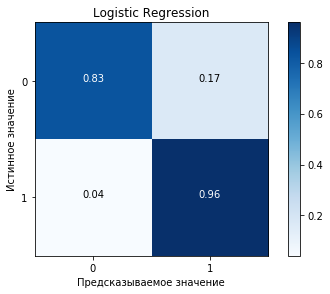

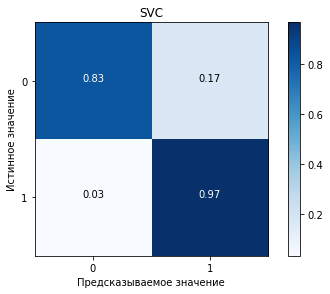

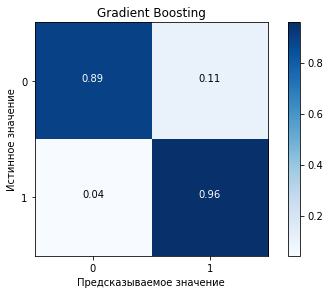

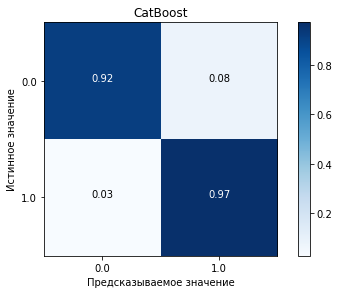

In [12]:
plot_confusion_matrix(
    confusion_matrix(reg_y_test_real, reg_y_test_pred), 
    classes=reg.classes_, 
    normalize=True,
    title='Logistic Regression'
)

plot_confusion_matrix(
    confusion_matrix(svc_y_test_real, svc_y_test_pred), 
    classes=svc.classes_,
    normalize=True,
    title='SVC'
)
plot_confusion_matrix(
    confusion_matrix(gb_y_test_real, gb_y_test_pred), 
    classes=gb.classes_,
    normalize=True,
    title='Gradient Boosting'
)
plot_confusion_matrix(
    confusion_matrix(cb_y_test_real, cb_y_test_pred), 
    classes=cb.classes_,
    normalize=True,
    title='CatBoost'
)

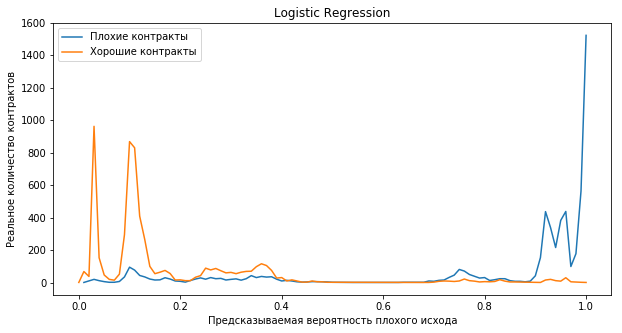

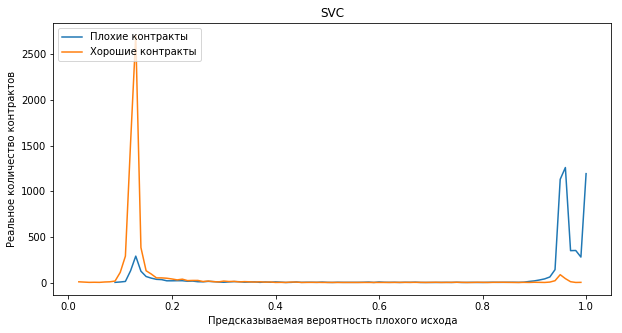

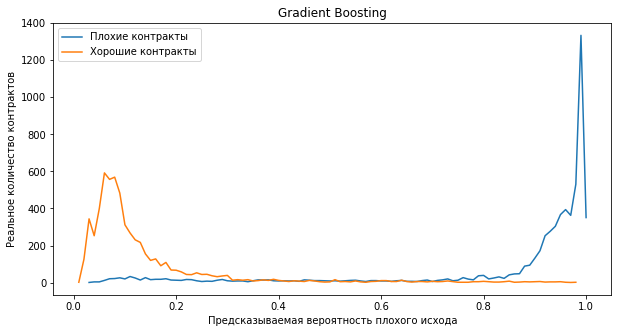

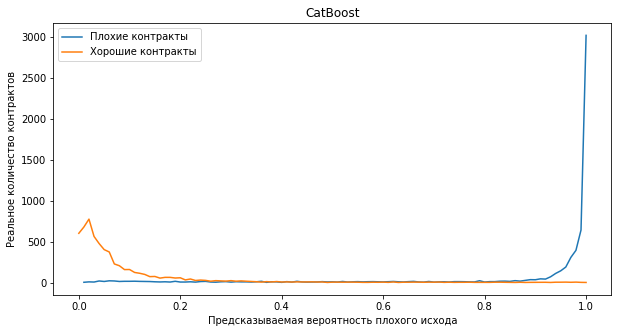

In [13]:
plot_dependence(reg_res, title='Logistic Regression')
plot_dependence(svc_res, title='SVC')
plot_dependence(gb_res, title='Gradient Boosting')
plot_dependence(cb_res, title='CatBoost')

### Ключевые для моделей признаки

In [44]:
sorted(zip(list(X_columns), list(reg.coef_[0])), key=lambda a: np.abs(a[1]), reverse=True)

[('price', 5.5571746134938076),
 ('okpd', 2.427313032139562),
 ('sup_no_pnl_share', -2.2574964181965589),
 ('pmp', -2.2232296148645125),
 ('sup_1s_org_sev', -1.7910184222145984),
 ('supType', 0.73580933135342297),
 ('sup_sim_price', -0.57179535879965671),
 ('sup_okpd_exp', 0.48237867716712435),
 ('sup_1s_sev', -0.3423787531105012),
 ('sup_cntr_avg_penalty', 0.25429964961505896),
 ('org_1s_sev', -0.18616193746538351),
 ('price_too_low', -0.11142556923684011),
 ('price_higher_pmp', 0.069465926343626389),
 ('orgForm', -0.031941696609376985),
 ('sup_cntr_num', 0.031287027476533447),
 ('sup_cntr_avg_price', -0.019613240680419222),
 ('org_cntr_num', 0.01493972497145373),
 ('org_1s_sup_sev', 0.01470363626858028)]

In [15]:
sorted(zip(list(X_columns), list(gb.feature_importances_)), key=lambda a: np.abs(a[1]), reverse=True)

[('orgForm', 0.17783669311546849),
 ('sup_cntr_avg_price', 0.14578074873277561),
 ('sup_cntr_num', 0.13573199498510519),
 ('supType', 0.12283132719712592),
 ('org_cntr_num', 0.080533501883002442),
 ('sup_okpd_exp', 0.07788892565430211),
 ('pmp', 0.063918437406572187),
 ('okpd', 0.052362926593513139),
 ('org_1s_sev', 0.03408134258595806),
 ('sup_sim_price', 0.031642527938572924),
 ('price', 0.025154450545034686),
 ('sup_1s_org_sev', 0.021540053123868044),
 ('sup_no_pnl_share', 0.013988943541415754),
 ('org_1s_sup_sev', 0.0090783333804545299),
 ('sup_cntr_avg_penalty', 0.0059559041400012334),
 ('price_higher_pmp', 0.0016738891768297249),
 ('sup_1s_sev', 0.0),
 ('price_too_low', 0.0)]

In [16]:
sorted(zip(list(X_columns), list(cb.feature_importances_)), key=lambda a: np.abs(a[1]), reverse=True)

[('sup_cntr_num', 22.204404239530902),
 ('orgForm', 14.65612724316233),
 ('sup_cntr_avg_price', 12.582598677811486),
 ('supType', 11.774748885016978),
 ('sup_okpd_exp', 11.457253931046772),
 ('okpd', 7.827608557538712),
 ('org_cntr_num', 6.8995812409102335),
 ('pmp', 4.692782908143021),
 ('sup_sim_price', 2.6307051661965954),
 ('price', 1.7441931672220448),
 ('org_1s_sev', 1.414295513941764),
 ('sup_1s_org_sev', 0.8007254948684943),
 ('sup_no_pnl_share', 0.6964236047284751),
 ('sup_cntr_avg_penalty', 0.2926437968928058),
 ('org_1s_sup_sev', 0.24573693800898122),
 ('price_too_low', 0.06339261942516325),
 ('sup_1s_sev', 0.013342332558248945),
 ('price_higher_pmp', 0.0034356829970062105)]

In [14]:
def get_classifier():
    classifiers = {
        "LR": (LogisticRegression, ParameterGrid({
            "C": [1, 4, 10],
            "n_jobs": [-1],
            'solver': ['liblinear', 'sag']
            })),
        "SVC": (SVC, ParameterGrid({
            "C": [1, 4, 10],
            "probability": [True],
            "decision_function_shape": ["ovr"]
        })),
        "GB": (GradientBoostingClassifier, ParameterGrid({
            "learning_rate": [0.3, 0.1],
            "n_estimators": [100, 240, 400],
            "max_depth": [1, 2, 3]
        })),
        "CB": (CatBoostClassifier, ParameterGrid({
            "learning_rate": [0.3, 0.1],
            "n_estimators": [100, 240, 400],
            "depth": [6, 8, 10],
            "logging_level": ['Silent'],
            "random_state": [random_seed]
        }))
    }
    
    for clf_name in classifiers:
        for params in classifiers[clf_name][1]:
            yield clf_name, params, classifiers[clf_name][0](**params)
                

In [15]:
def choose_best_classifier(X, X_cat, y, kfolds=10, valid=0.2):
    start_time = time.time()
    X_no_cat = X.copy()
    val_ind = int(X.shape[0] * valid)
    
    best_clf_name = None
    best_params = None
    
    best_test_log_loss = None
    best_y_test_pred = None
    best_y_test_pred_proba = None
    best_y_test_real = None
    
    best_y_valid_pred = None
    best_y_valid_pred_proba = np.zeros((0, 2))
    best_y_valid_real = None
    best_valid_log_loss = 100
    
    y_valid = y[:val_ind]
    y = y[val_ind:]
    
    for clf_name, params, clf in get_classifier():
        X = X_cat if clf_name in ('LR', 'SVC') else X_no_cat
        
        X_valid = X[:val_ind,:]
        X = X[val_ind:,:]
        
        y_train_pred = np.array([])
        y_train_real = np.array([])
        y_test_pred = np.array([])
        y_test_pred_proba = np.zeros((0, 2))
        y_test_real = np.array([])
        
        kfold_generator = KFold(n_splits=kfolds, shuffle=True, random_state=random_seed)
        for train_index, test_index in kfold_generator.split(X):
            X_train = X[train_index]
            y_train = y[train_index]

            X_test = X[test_index]
            y_test = y[test_index]
            
            if clf_name == 'CB':
                clf.fit(X_train, y_train, cat_features=[11, 12, 17])
            else:   
                clf.fit(X_train, y_train)
            
            y_train_pred = np.concatenate((y_train_pred, clf.predict(X_train)))
            y_train_real = np.concatenate((y_train_real, y_train))
            y_test_pred = np.concatenate((y_test_pred, clf.predict(X_test)))
            y_test_pred_proba = np.concatenate((y_test_pred_proba, clf.predict_proba(X_test)))
            y_test_real = np.concatenate((y_test_real, y_test))

        if log_loss(y_valid, clf.predict_proba(X_valid)) < best_valid_log_loss:
            best_clf_name = clf_name
            best_params = params
            
            best_test_log_loss = log_loss(y_test_real, y_test_pred_proba)
            best_y_test_pred = y_test_pred
            best_y_test_pred_proba = y_test_pred_proba
            best_y_test_real = y_test_real
            
            best_y_valid_pred = clf.predict(X_valid)
            best_y_valid_pred_proba = clf.predict_proba(X_valid)
            best_y_valid_real = y_valid
            best_valid_log_loss = log_loss(y_valid, best_y_valid_pred_proba)

        print("{} {} train_acc: {:.3f} test_acc: {:.3f} test_ll {:.3f} valid_acc: {:.3f} valid_ll: {:.3f}".format(
            clf_name,
            params,
            accuracy_score(y_train_pred, y_train_real),
            accuracy_score(y_test_pred, y_test_real),
            log_loss(y_test_real, y_test_pred_proba),
            accuracy_score(clf.predict(X_valid), y_valid),
            log_loss(y_valid, clf.predict_proba(X_valid))
        ))
        
    print("Лучший {} {} с valid_acc: {:.3f}, valid_ll: {:.3f}".format(
        best_clf_name,
        best_params,
        accuracy_score(best_y_valid_real, best_y_valid_pred),
        log_loss(best_y_valid_real, best_y_valid_pred_proba)
    ))

    print(classification_report(
        best_y_valid_real,
        best_y_valid_pred,
        target_names=tuple(("Плохой", "Хороший"))
    ))
    
    print("Выбор лучшего классификатора занял %s секунд" % int((time.time() - start_time)))

In [94]:
choose_best_classifier(X, X_cat, y)

/Users/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LR {'C': 1, 'n_jobs': -1, 'solver': 'liblinear'} train_acc: 0.896 test_acc: 0.895 test_ll 0.284 valid_acc: 0.895 valid_ll: 0.287


/Users/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LR {'C': 1, 'n_jobs': -1, 'solver': 'sag'} train_acc: 0.893 test_acc: 0.893 test_ll 0.292 valid_acc: 0.895 valid_ll: 0.294
LR {'C': 4, 'n_jobs': -1, 'solver': 'liblinear'} train_acc: 0.896 test_acc: 0.895 test_ll 0.283 valid_acc: 0.895 valid_ll: 0.286
LR {'C': 4, 'n_jobs': -1, 'solver': 'sag'} train_acc: 0.893 test_acc: 0.893 test_ll 0.291 valid_acc: 0.895 valid_ll: 0.293
LR {'C': 10, 'n_jobs': -1, 'solver': 'liblinear'} train_acc: 0.896 test_acc: 0.895 test_ll 0.283 valid_acc: 0.895 valid_ll: 0.286
LR {'C': 10, 'n_jobs': -1, 'solver': 'sag'} train_acc: 0.893 test_acc: 0.893 test_ll 0.291 valid_acc: 0.895 valid_ll: 0.293
SVC {'C': 1, 'decision_function_shape': 'ovr', 'probability': True} train_acc: 0.898 test_acc: 0.896 test_ll 0.290 valid_acc: 0.894 valid_ll: 0.286
SVC {'C': 4, 'decision_function_shape': 'ovr', 'probability': True} train_acc: 0.903 test_acc: 0.900 test_ll 0.286 valid_acc: 0.900 valid_ll: 0.280
SVC {'C': 10, 'decision_function_shape': 'ovr', 'probability': True} train_

In [16]:
def learn_one_model(classifier, clf_name, X_, y_, kfold=10, valid=None):
    """Функция для обучения одной модели"""
    
    start_time = time.time()

    y_train_real = np.array([])
    y_test_real = np.array([])
    y_train_pred = np.array([])
    y_test_pred = np.array([])
    y_test_pred_proba = np.zeros((0, 2))
    
    if valid:
        val_ind = int(X_.shape[0] * valid)
        X_valid = X_[:val_ind,:]
        X_ = X_[val_ind:,:]
        y_valid = y_[:val_ind]
        y_ = y_[val_ind:]
    
    kfolds_generator = KFold(n_splits=kfold, shuffle=True, random_state=random_seed)
    for idx, (train_index, test_index) in enumerate(kfolds_generator.split(X_)):
        print('Обучение {} разбиения'.format(idx + 1))
        
        X_train = X_[train_index]
        X_test = X_[test_index]
    
        y_train = y_[train_index]
        y_test = y_[test_index]
    
        classifier.fit(X_train, y_train)
    
        y_train_real = np.concatenate((y_train_real, y_train))
        y_test_real = np.concatenate((y_test_real, y_test))
        y_train_pred = np.concatenate((y_train_pred, classifier.predict(X_train)))
        y_test_pred = np.concatenate((y_test_pred, classifier.predict(X_test)))
        y_test_pred_proba = np.concatenate((y_test_pred_proba, classifier.predict_proba(X_test))) 
    print("Обучение заняло %s секунд\n" % (time.time() - start_time))
    print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba)
    
    if valid:
        print('Данные на валидационной выборке')
        print(classification_report(y_valid, classifier.predict(X_valid), target_names=tuple(("Плохой", "Хороший"))))
              
    res, res_corr = real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba)
    print(res_corr)
    plot_confusion_matrix(
        confusion_matrix(y_test_real, y_test_pred), 
        classes=classifier.classes_, 
        # normalize=True,
        title='Confusion matrix, without normalization'
    )
    plot_dependence(res)
    plot_roc_curve(y_test_real, y_test_pred)
    return classifier

Обучение 1 разбиения
Обучение 2 разбиения
Обучение 3 разбиения
Обучение 4 разбиения
Обучение 5 разбиения
Обучение 6 разбиения
Обучение 7 разбиения
Обучение 8 разбиения
Обучение 9 разбиения
Обучение 10 разбиения
Обучение заняло 413.4085612297058 секунд

CAT BOOST

             precision    recall  f1-score   support

     Плохой       0.97      0.92      0.95      5926
    Хороший       0.93      0.97      0.95      5981

avg / total       0.95      0.95      0.95     11907

Точность 0.962 на обучающей выборке
Точность 0.948 на тестовой выборке
Потеря перекрестной энтропии 0.143


              result  proba_pred      pred
result      1.000000   -0.916210  0.897295
proba_pred -0.916210    1.000000 -0.977617
pred        0.897295   -0.977617  1.000000


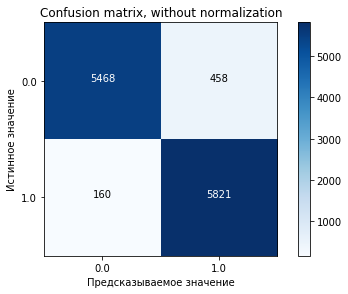

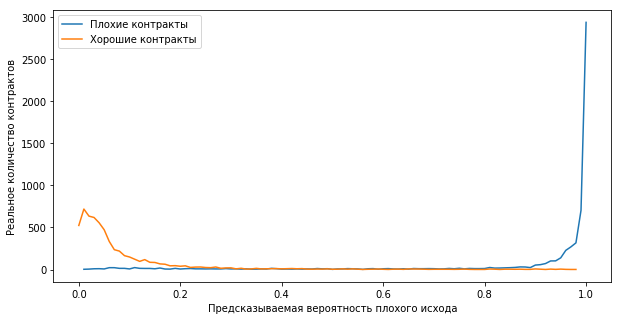

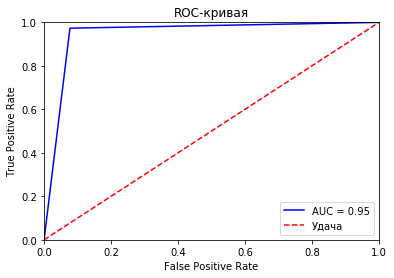

In [17]:
learn_one_model(CatBoostClassifier(logging_level='Silent', random_state=random_seed), 'Cat Boost', X, y)